# Final Project 
## Complete Machine Learning Pipeline for MIMIC Classification

### Mariajose Argote


In [1]:
EDA = True

### Objective
Build a classification pipeline to predict `HOSPITAL_EXPIRE_FLAG` (patient mortality during ICU stay) using the MIMIC-III dataset subset with 20,885 ICU patient observations.

### Success Criteria
- Working, reproducible Jupyter notebook with complete ML pipeline
- Predictions submitted as probabilities (.predict_proba) in CSV format
- Top-tier prediction ranking (within reasonable distance of best performer)
- Ability to defend all modeling decisions during in-person presentation
- Grade target: 9/10 from presentation + up to 1/10 from prediction ranking

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jinja2

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [21]:
# Generate a random seed for reproducibility
# np.random.seed() has a range of [0, 2**32 - 1] for the seed value
print(np.random.randint(0, 2**30))

SEED = 244459055

np.random.seed(SEED)
#540921260


540921260


### 1.1 Import MIMIC Data

In [71]:
# Import data

train = pd.read_csv('MIMIC III dataset HEF/mimic_train_HEF.csv')
test= pd.read_csv('MIMIC III dataset HEF/mimic_test_HEF.csv')


# Display first few rows of the dataset

print(train.info())

train.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HOSPITAL_EXPIRE_FLAG  20885 non-null  int64  
 1   subject_id            20885 non-null  int64  
 2   hadm_id               20885 non-null  int64  
 3   icustay_id            20885 non-null  int64  
 4   HeartRate_Min         18698 non-null  float64
 5   HeartRate_Max         18698 non-null  float64
 6   HeartRate_Mean        18698 non-null  float64
 7   SysBP_Min             18677 non-null  float64
 8   SysBP_Max             18677 non-null  float64
 9   SysBP_Mean            18677 non-null  float64
 10  DiasBP_Min            18676 non-null  float64
 11  DiasBP_Max            18676 non-null  float64
 12  DiasBP_Mean           18676 non-null  float64
 13  MeanBP_Min            18699 non-null  float64
 14  MeanBP_Max            18699 non-null  float64
 15  MeanBP_Mean        

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,LOS
count,20885.000000,20885.000000,20885.000000,20885.000000,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,...,18388.000000,18388.000000,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000,20885.000000,20885.000000
mean,0.112282,58950.496098,150082.402298,250202.495523,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,...,37.428781,36.751717,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428,-51617.069830,3.701046
std,0.315720,25299.439535,28898.479845,28909.806302,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,...,0.799897,0.603476,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145,10686.395846,5.175721
min,0.000000,23.000000,100001.000000,200001.000000,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,...,30.800000,30.666667,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000,-72740.274440,0.056600
25%,0.000000,41132.000000,125157.000000,225153.000000,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,...,36.944444,36.388889,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000,-60864.454110,1.165400
50%,0.000000,60441.000000,150152.000000,250452.000000,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,...,37.333333,36.731481,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667,-51561.703460,2.020800
75%,0.000000,80286.000000,175017.000000,275303.000000,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,...,37.888889,37.092593,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571,-42327.560030,3.915800
max,1.000000,99999.000000,199999.000000,299998.000000,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,...,42.000000,40.238333,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000,-32157.494580,101.739000


In [72]:
train.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


### 1.2 Check data types, missing values, distributions

Visual Inspection
* 10% of heart rate and blood pressure columns are missing / blank
* 11% of SYS and DiasBP columns are missing /blank
* 10% missing respiration rate columns
* 12% missing temperature information
* 11% missing SPO2 columns information


In [73]:
print(test.info())
test.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5221 entries, 0 to 5220
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      5221 non-null   int64  
 1   hadm_id         5221 non-null   int64  
 2   icustay_id      5221 non-null   int64  
 3   HeartRate_Min   4676 non-null   float64
 4   HeartRate_Max   4676 non-null   float64
 5   HeartRate_Mean  4676 non-null   float64
 6   SysBP_Min       4670 non-null   float64
 7   SysBP_Max       4670 non-null   float64
 8   SysBP_Mean      4670 non-null   float64
 9   DiasBP_Min      4669 non-null   float64
 10  DiasBP_Max      4669 non-null   float64
 11  DiasBP_Mean     4669 non-null   float64
 12  MeanBP_Min      4674 non-null   float64
 13  MeanBP_Max      4674 non-null   float64
 14  MeanBP_Mean     4674 non-null   float64
 15  RespRate_Min    4675 non-null   float64
 16  RespRate_Max    4675 non-null   float64
 17  RespRate_Mean   4675 non-null   f

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff
count,5221.000000,5221.000000,5221.000000,4676.000000,4676.000000,4676.000000,4670.000000,4670.000000,4670.000000,4669.000000,...,4583.000000,4583.000000,4583.000000,4670.000000,4670.000000,4670.000000,5163.000000,5163.000000,5163.000000,5221.000000
mean,58870.629573,150248.186746,249925.293239,69.942686,105.279940,85.221128,90.862392,150.547966,118.763143,44.142643,...,36.041879,37.441470,36.755418,90.828480,99.553319,96.857538,107.823494,376.578346,163.521697,-51606.334303
std,25320.956194,28679.538155,28763.030681,15.013524,21.247956,15.484126,17.529140,23.575450,16.490767,11.695481,...,0.762967,0.797153,0.595941,7.660437,1.516541,2.406957,34.312518,13915.510710,1739.829727,10666.881712
min,107.000000,100033.000000,200011.000000,1.000000,42.000000,36.000000,10.000000,62.000000,51.750000,6.000000,...,22.777778,32.555556,32.222222,1.000000,42.000000,42.000000,15.000000,32.000000,32.000000,-72639.620300
25%,41055.000000,125246.000000,225118.000000,60.000000,90.000000,74.035131,81.000000,134.000000,106.752976,37.000000,...,35.666667,36.944444,36.409722,90.000000,100.000000,95.840227,87.000000,126.000000,111.500000,-60840.730090
50%,60057.000000,150492.000000,249759.000000,69.000000,104.000000,83.957428,90.000000,148.000000,116.807407,44.000000,...,36.111111,37.333333,36.738095,92.000000,100.000000,97.134848,102.000000,160.000000,129.000000,-51612.812060
75%,80313.000000,174983.000000,274576.000000,79.000000,118.000000,95.477143,101.000000,164.000000,128.862844,51.000000,...,36.500000,37.888889,37.091705,94.000000,100.000000,98.333333,122.000000,205.000000,155.060976,-42552.065720
max,99992.000000,199967.000000,299979.000000,143.000000,220.000000,155.571429,162.000000,290.000000,195.250000,97.000000,...,39.388889,41.111111,39.527778,100.000000,100.000000,100.000000,374.000000,999999.000000,125110.125000,-32176.628480


In [74]:
# Check train/test column consistency
target_col = "HOSPITAL_EXPIRE_FLAG"
leaky_cols = ['LOS', 'DOD', 'DISCHTIME','DEATHTIME'] #must drop for modeling
id_cols      = ["subject_id", "hadm_id", "icustay_id"]

# Groups 
vital_cols = [  # 24 cols: min/max/mean of each
    
    "HeartRate_Min", "HeartRate_Max", "HeartRate_Mean",
    "SysBP_Min", "SysBP_Max", "SysBP_Mean",
    "DiasBP_Min", "DiasBP_Max", "DiasBP_Mean",
    "MeanBP_Min", "MeanBP_Max", "MeanBP_Mean",
    "RespRate_Min", "RespRate_Max", "RespRate_Mean",
    "TempC_Min", "TempC_Max", "TempC_Mean",
    "SpO2_Min", "SpO2_Max", "SpO2_Mean",
    "Glucose_Mean", "Glucose_Max", "Glucose_Min"
]

temporal_cols = ["DOB", "ADMITTIME", "DISCHTIME", "Diff"]

demographic_cols = ["GENDER", "ADMISSION_TYPE", "INSURANCE",
             "RELIGION", "MARITAL_STATUS", "ETHNICITY"]

clinical_cols = ["DIAGNOSIS", "ICD9_diagnosis", "FIRST_CAREUNIT"]


# Columns to use as features in train
exclude_cols = set([target_col]) | set(leaky_cols) | set(id_cols)
feature_cols = [c for c in train.columns if c not in exclude_cols]

# Working copy and drop giveaways up front
train = train.copy()
train_model = train.drop(columns=leaky_cols, errors="ignore")

In [75]:

# 1) Check that test has all feature columns
missing_in_test = set(feature_cols) - set(test.columns)
extra_in_test   = set(test.columns) - set(feature_cols)
print("Missing in test:", missing_in_test)
print("Extra in test  :", extra_in_test)

# 2) Reorder test columns to match train's feature order
test = test[feature_cols]


#checking for column type consistency
shared = set(train_model.columns) & set(test.columns)
dtype_diff = {
    col: (train_model[col].dtype, test[col].dtype)
    for col in shared
    if train_model[col].dtype != test[col].dtype
}
print("Columns with different dtypes:", dtype_diff)


Missing in test: set()
Extra in test  : {'subject_id', 'hadm_id', 'icustay_id'}
Columns with different dtypes: {}


In [76]:
#Check missing values - columns

def missing_summary(train):
    n = len(train)
    miss_cnt = train.isna().sum()
    miss_pct = miss_cnt / n
    return (
        pd.DataFrame({
            "n_missing": miss_cnt,
            "pct_missing": miss_pct
        })
        .sort_values("pct_missing", ascending=False)
    )

col_missing = missing_summary(train.drop(columns=id_cols, errors="ignore")
                              .drop(columns=leaky_cols, errors="ignore"))
print(col_missing.head(15))

#Check missing values - rows
row_missing_count = train_model.isna().sum(axis=1)
row_missing_frac  = row_missing_count / train_model.shape[1]

print("Rows with ANY missing:", (row_missing_count > 0).mean())
print("Rows with > 20% missing:", (row_missing_frac > 0.2).mean())
print("Rows with > 50% missing:", (row_missing_frac > 0.5).mean())


               n_missing  pct_missing
TempC_Max           2497     0.119559
TempC_Mean          2497     0.119559
TempC_Min           2497     0.119559
DiasBP_Max          2209     0.105770
DiasBP_Mean         2209     0.105770
DiasBP_Min          2209     0.105770
SysBP_Min           2208     0.105722
SysBP_Max           2208     0.105722
SysBP_Mean          2208     0.105722
SpO2_Max            2203     0.105482
SpO2_Min            2203     0.105482
SpO2_Mean           2203     0.105482
RespRate_Min        2189     0.104812
RespRate_Max        2189     0.104812
RespRate_Mean       2189     0.104812
Rows with ANY missing: 0.16322719655254966
Rows with > 20% missing: 0.10490782858510893
Rows with > 50% missing: 0.10452477854919799


In [77]:
#check if vital signs are missing together in rows

vital_cols_present = [c for c in vital_cols if c in train_model.columns] 

missing_vitals = train_model[vital_cols_present].isna()

# Fraction of rows with at least one missing vital
rows_any_vital_missing  = missing_vitals.any(axis=1)
# Fraction of rows with all vitals missing
rows_all_vitals_missing = missing_vitals.all(axis=1)

print("Frac rows with ANY vital missing   :", rows_any_vital_missing.mean().round(3))
print("Frac rows with ALL vitals missing  :", rows_all_vitals_missing.mean().round(3))

# See patterns of missingness across vitals
pattern_counts = missing_vitals.value_counts()
print(pattern_counts.head(10))


Frac rows with ANY vital missing   : 0.133
Frac rows with ALL vitals missing  : 0.0
HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  MeanBP_Min  MeanBP_Max  MeanBP_Mean  RespRate_Min  RespRate_Max  RespRate_Mean  TempC_Min  TempC_Max  TempC_Mean  SpO2_Min  SpO2_Max  SpO2_Mean  Glucose_Mean  Glucose_Max  Glucose_Min
False          False          False           False      False      False       False       False       False        False       False       False        False         False         False          False      False      False       False     False     False      False         False        False          18113
True           True           True            True       True       True        True        True        True         True        True        True         True          True          True           True       True       True        True      True      True       False         False        False           

In [78]:
#exploring those rows where vitals are missing

# Count missing + present vitals per row
n_vitals_missing  = train_model[vital_cols].isna().sum(axis=1)
n_vitals_present  = train_model[vital_cols].notna().sum(axis=1)
frac_vitals_missing = n_vitals_missing / len(vital_cols)

# Quick sanity check:
print(n_vitals_missing.value_counts().sort_index().head(30))
print("Rows with 21 missing vitals:", (n_vitals_missing == 21).sum())

mask_21_missing = (n_vitals_missing == 21)

print("Mortality rate, 21-missing group:",
    train_model.loc[mask_21_missing, target_col].mean().round(3))

print("Mortality rate, others:",
  train_model.loc[~mask_21_missing, target_col].mean().round(3))

0     18113
3       545
6        36
9         3
12        2
15        1
18        2
21     2183
Name: count, dtype: int64
Rows with 21 missing vitals: 2183
Mortality rate, 21-missing group: 0.113
Mortality rate, others: 0.112


In [79]:
# Define threshold: drop rows with 21 or more missing vitals
THRESH_MISSING_VITALS = 21

mask_drop_extreme_vital_missing = (n_vitals_missing >= THRESH_MISSING_VITALS)

print("Dropping rows with >= 21 missing vitals:",
      mask_drop_extreme_vital_missing.mean().round(3), "of all rows")

train_model_clean = train_model.loc[~mask_drop_extreme_vital_missing].copy()


Dropping rows with >= 21 missing vitals: 0.105 of all rows


Because vital signs are central to our mortality prediction, I removed ICU stays where ≥ 87.5% of vital-sign summary features were missing (2,183 out of 20,885 stays). For the remaining patients, the plan is to impute the missing vitals using median/mean values within the training set.

In [82]:
#checking different dataframe sizes

print("train shape:", train.shape)
print("train_model shape:", train_model.shape)
print("train_model_clean shape:", train_model_clean.shape)

train_model_clean.head()

train shape: (20885, 44)
train_model shape: (20885, 40)
train_model_clean shape: (18702, 40)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,2178-02-06 10:35:00,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,2129-02-12 22:34:00,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,2125-11-17 23:04:00,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,2131-01-26 08:00:00,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU
5,0,63311,180102,287519,70.0,130.0,97.951220,107.0,155.0,128.414634,...,2151-08-06 19:11:00,-51044.77754,EMERGENCY,Private,CATHOLIC,SINGLE,WHITE,LARGE GASTOINTESTINAL BLEED,5550,MICU


In [ ]:
#checking missing data by columns after clean drop

col_missing = missing_summary(train_model_clean.drop(columns=id_cols, errors="ignore"))
col_missing.head(20)


,n_missing,pct_missing
MARITAL_STATUS,683,0.036520
TempC_Mean,314,0.016790
TempC_Min,314,0.016790
TempC_Max,314,0.016790
Glucose_Max,253,0.013528
Glucose_Min,253,0.013528
Glucose_Mean,253,0.013528
DiasBP_Mean,26,0.001390
DiasBP_Max,26,0.001390
DiasBP_Min,26,0.001390


### 1.3 Identify and visualize class imbalance in target

88.8% of ICU stays survived in the cleaned training set, this indicates strong class imbalance in the target

In [85]:
train_model_clean[target_col].value_counts(normalize=True)

#88.8% of ICU stays survived in the cleaned training set


HOSPITAL_EXPIRE_FLAG
0    0.887819
1    0.112181
Name: proportion, dtype: float64

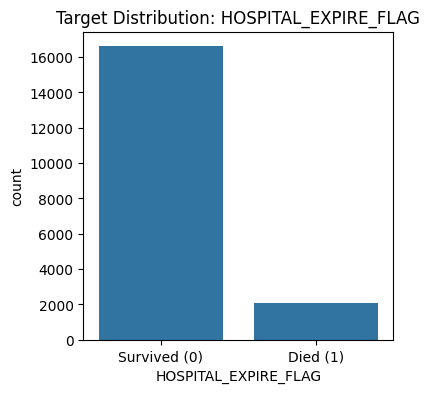

In [ ]:
#plotting target distribution after cleaning

plt.figure(figsize=(4,4))
sns.countplot(x=target_col, data=train_model_clean)
plt.title("Target Distribution: HOSPITAL_EXPIRE_FLAG")
plt.xticks([0, 1], ["Survived (0)", "Died (1)"])
plt.show()


### 1.4 Examine correlations between vital signs

In [ ]:
vitals_present = [c for c in vital_cols if c in train_model_clean.columns]

vital_means = [c for c in vitals_present if c.endswith("_Mean")]

train_model_clean[vital_means].describe()

,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean
count,18698.000000,18677.000000,18676.000000,18699.000000,18696.000000,18388.000000,18682.000000,18449.000000
mean,85.180250,119.145423,62.511614,77.609535,18.985855,36.751717,96.866685,139.033918
std,15.318208,16.701503,11.010790,11.113299,3.849713,0.603476,2.333108,44.437267
min,34.714286,46.000000,17.000000,25.759907,9.291667,30.666667,47.666667,43.250000
25%,74.272727,107.100000,54.950952,70.033908,16.250000,36.388889,95.812500,111.000000
50%,84.131183,116.901961,61.423660,76.294118,18.382353,36.731481,97.142857,129.000000
75%,95.185588,129.465116,68.954545,84.041774,21.105543,37.092593,98.346154,155.000000
max,163.875000,202.172414,121.489362,136.652174,41.235294,40.238333,100.000000,771.900000


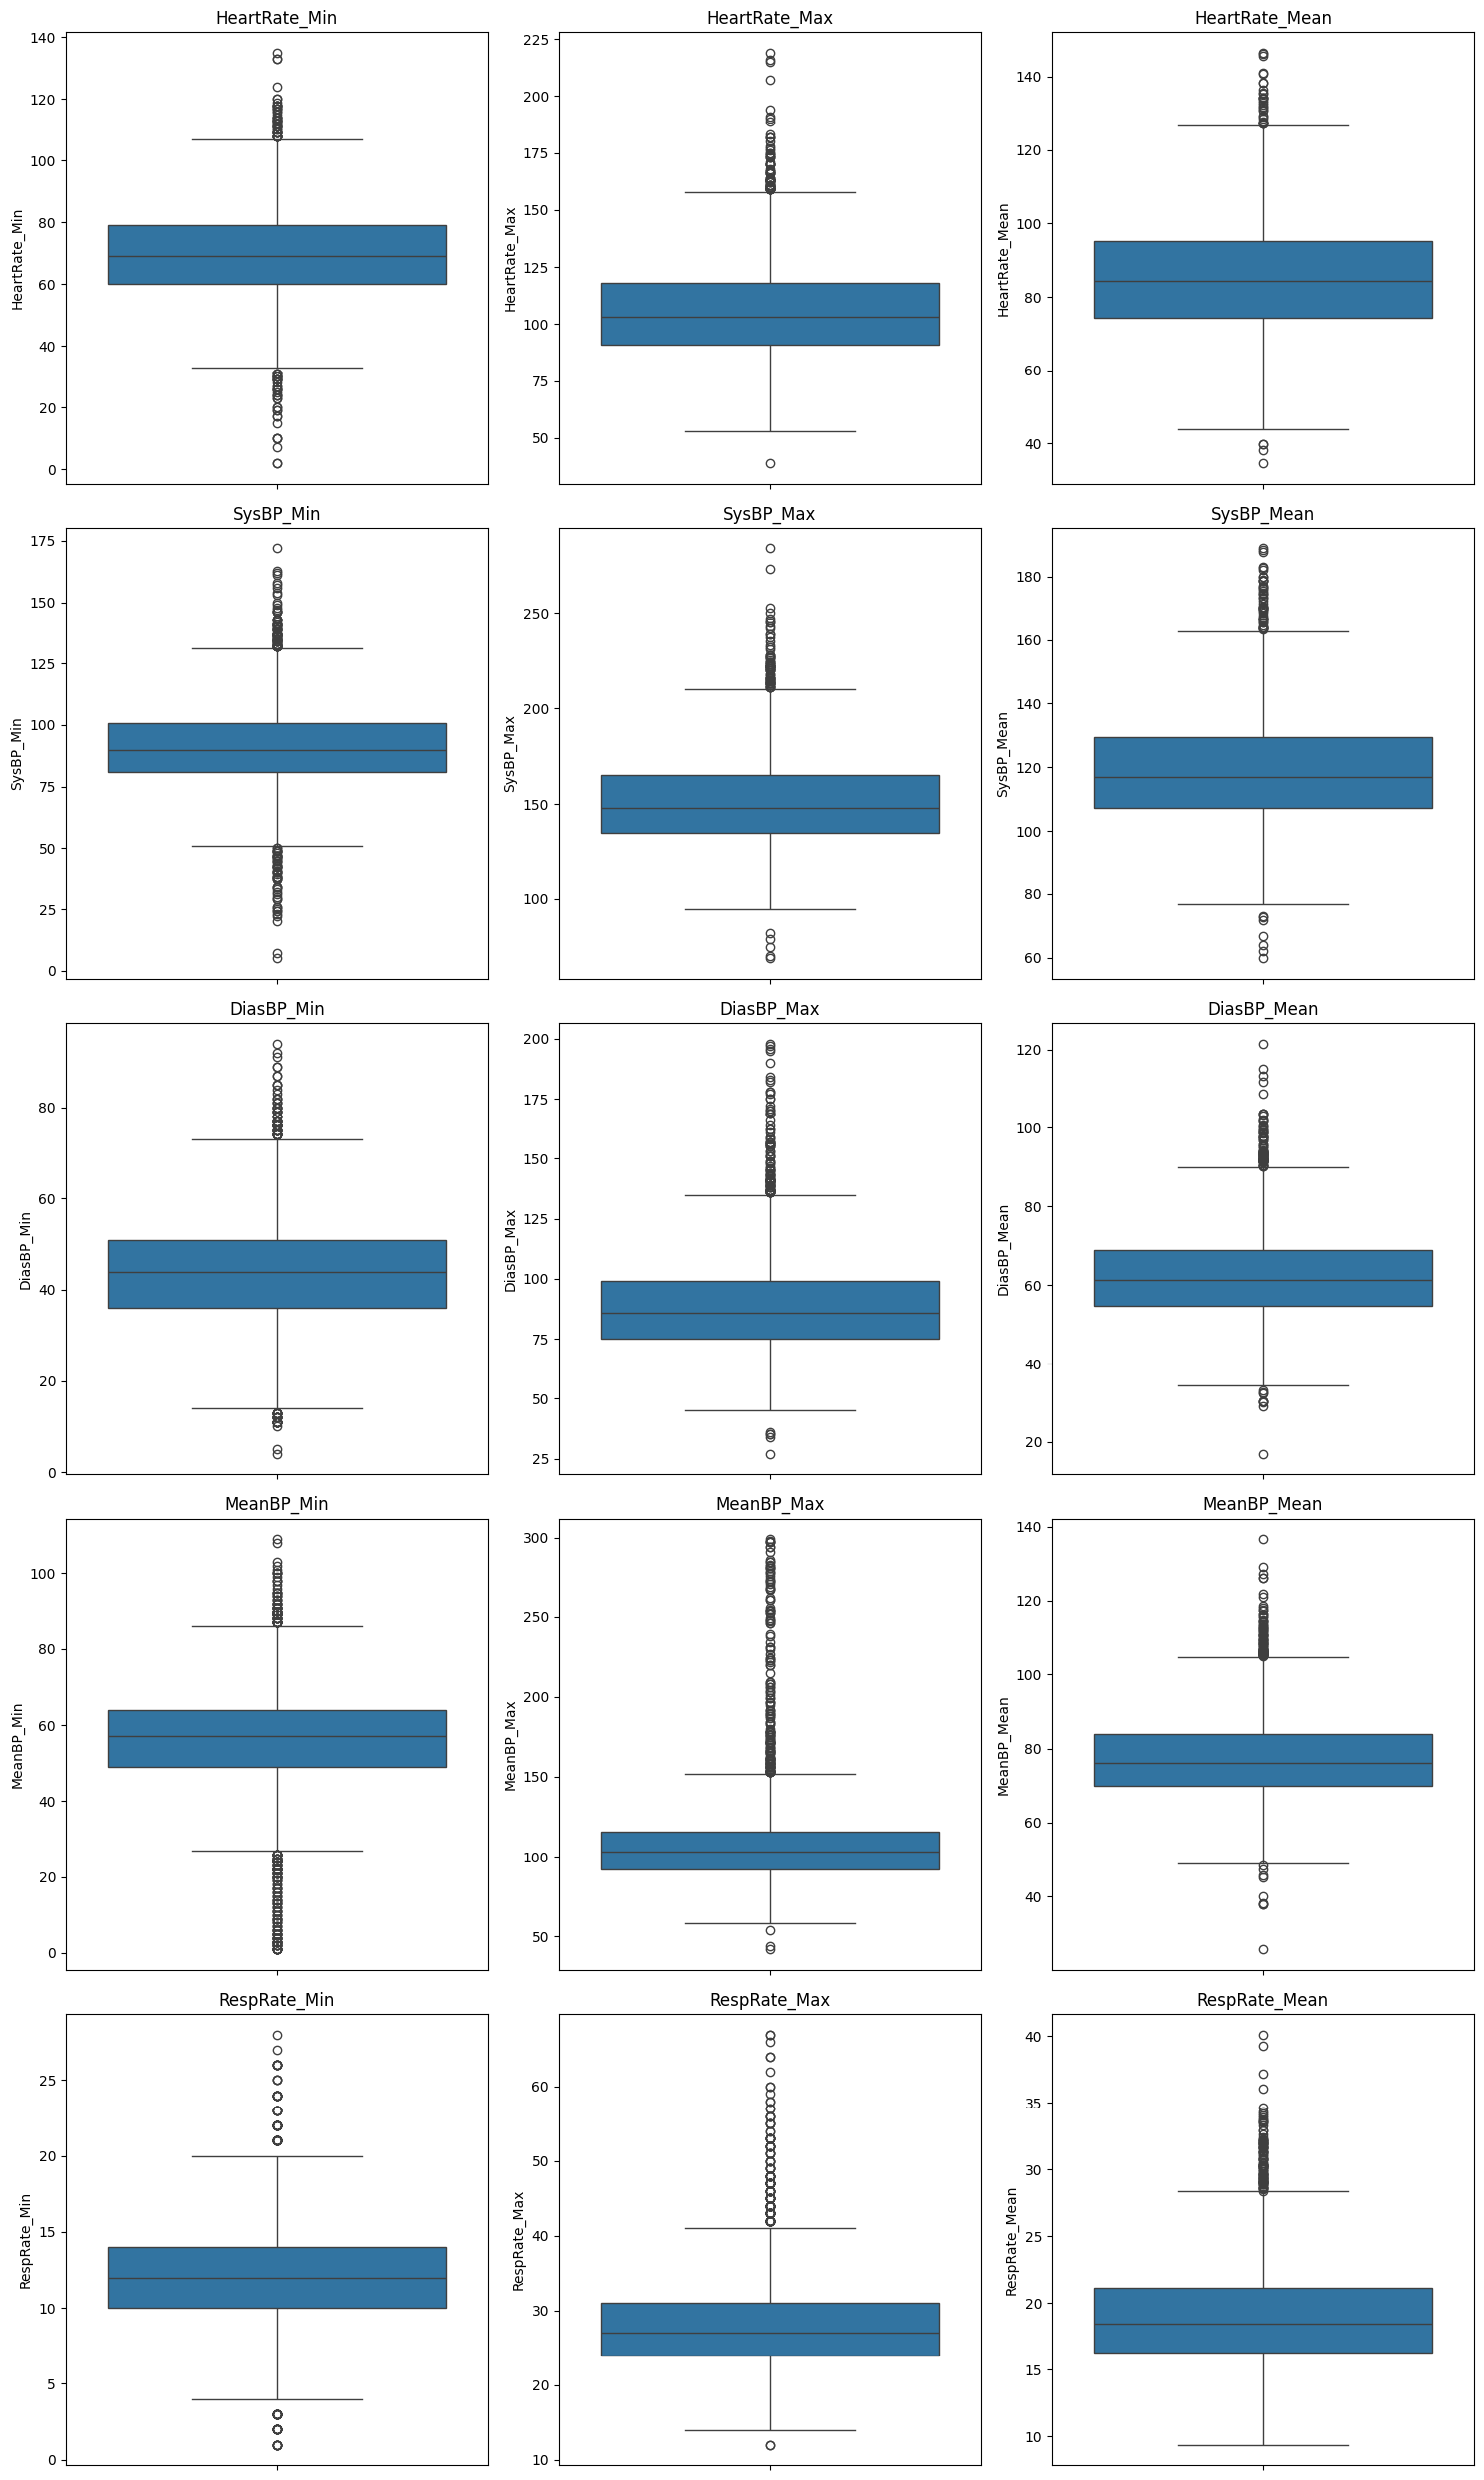

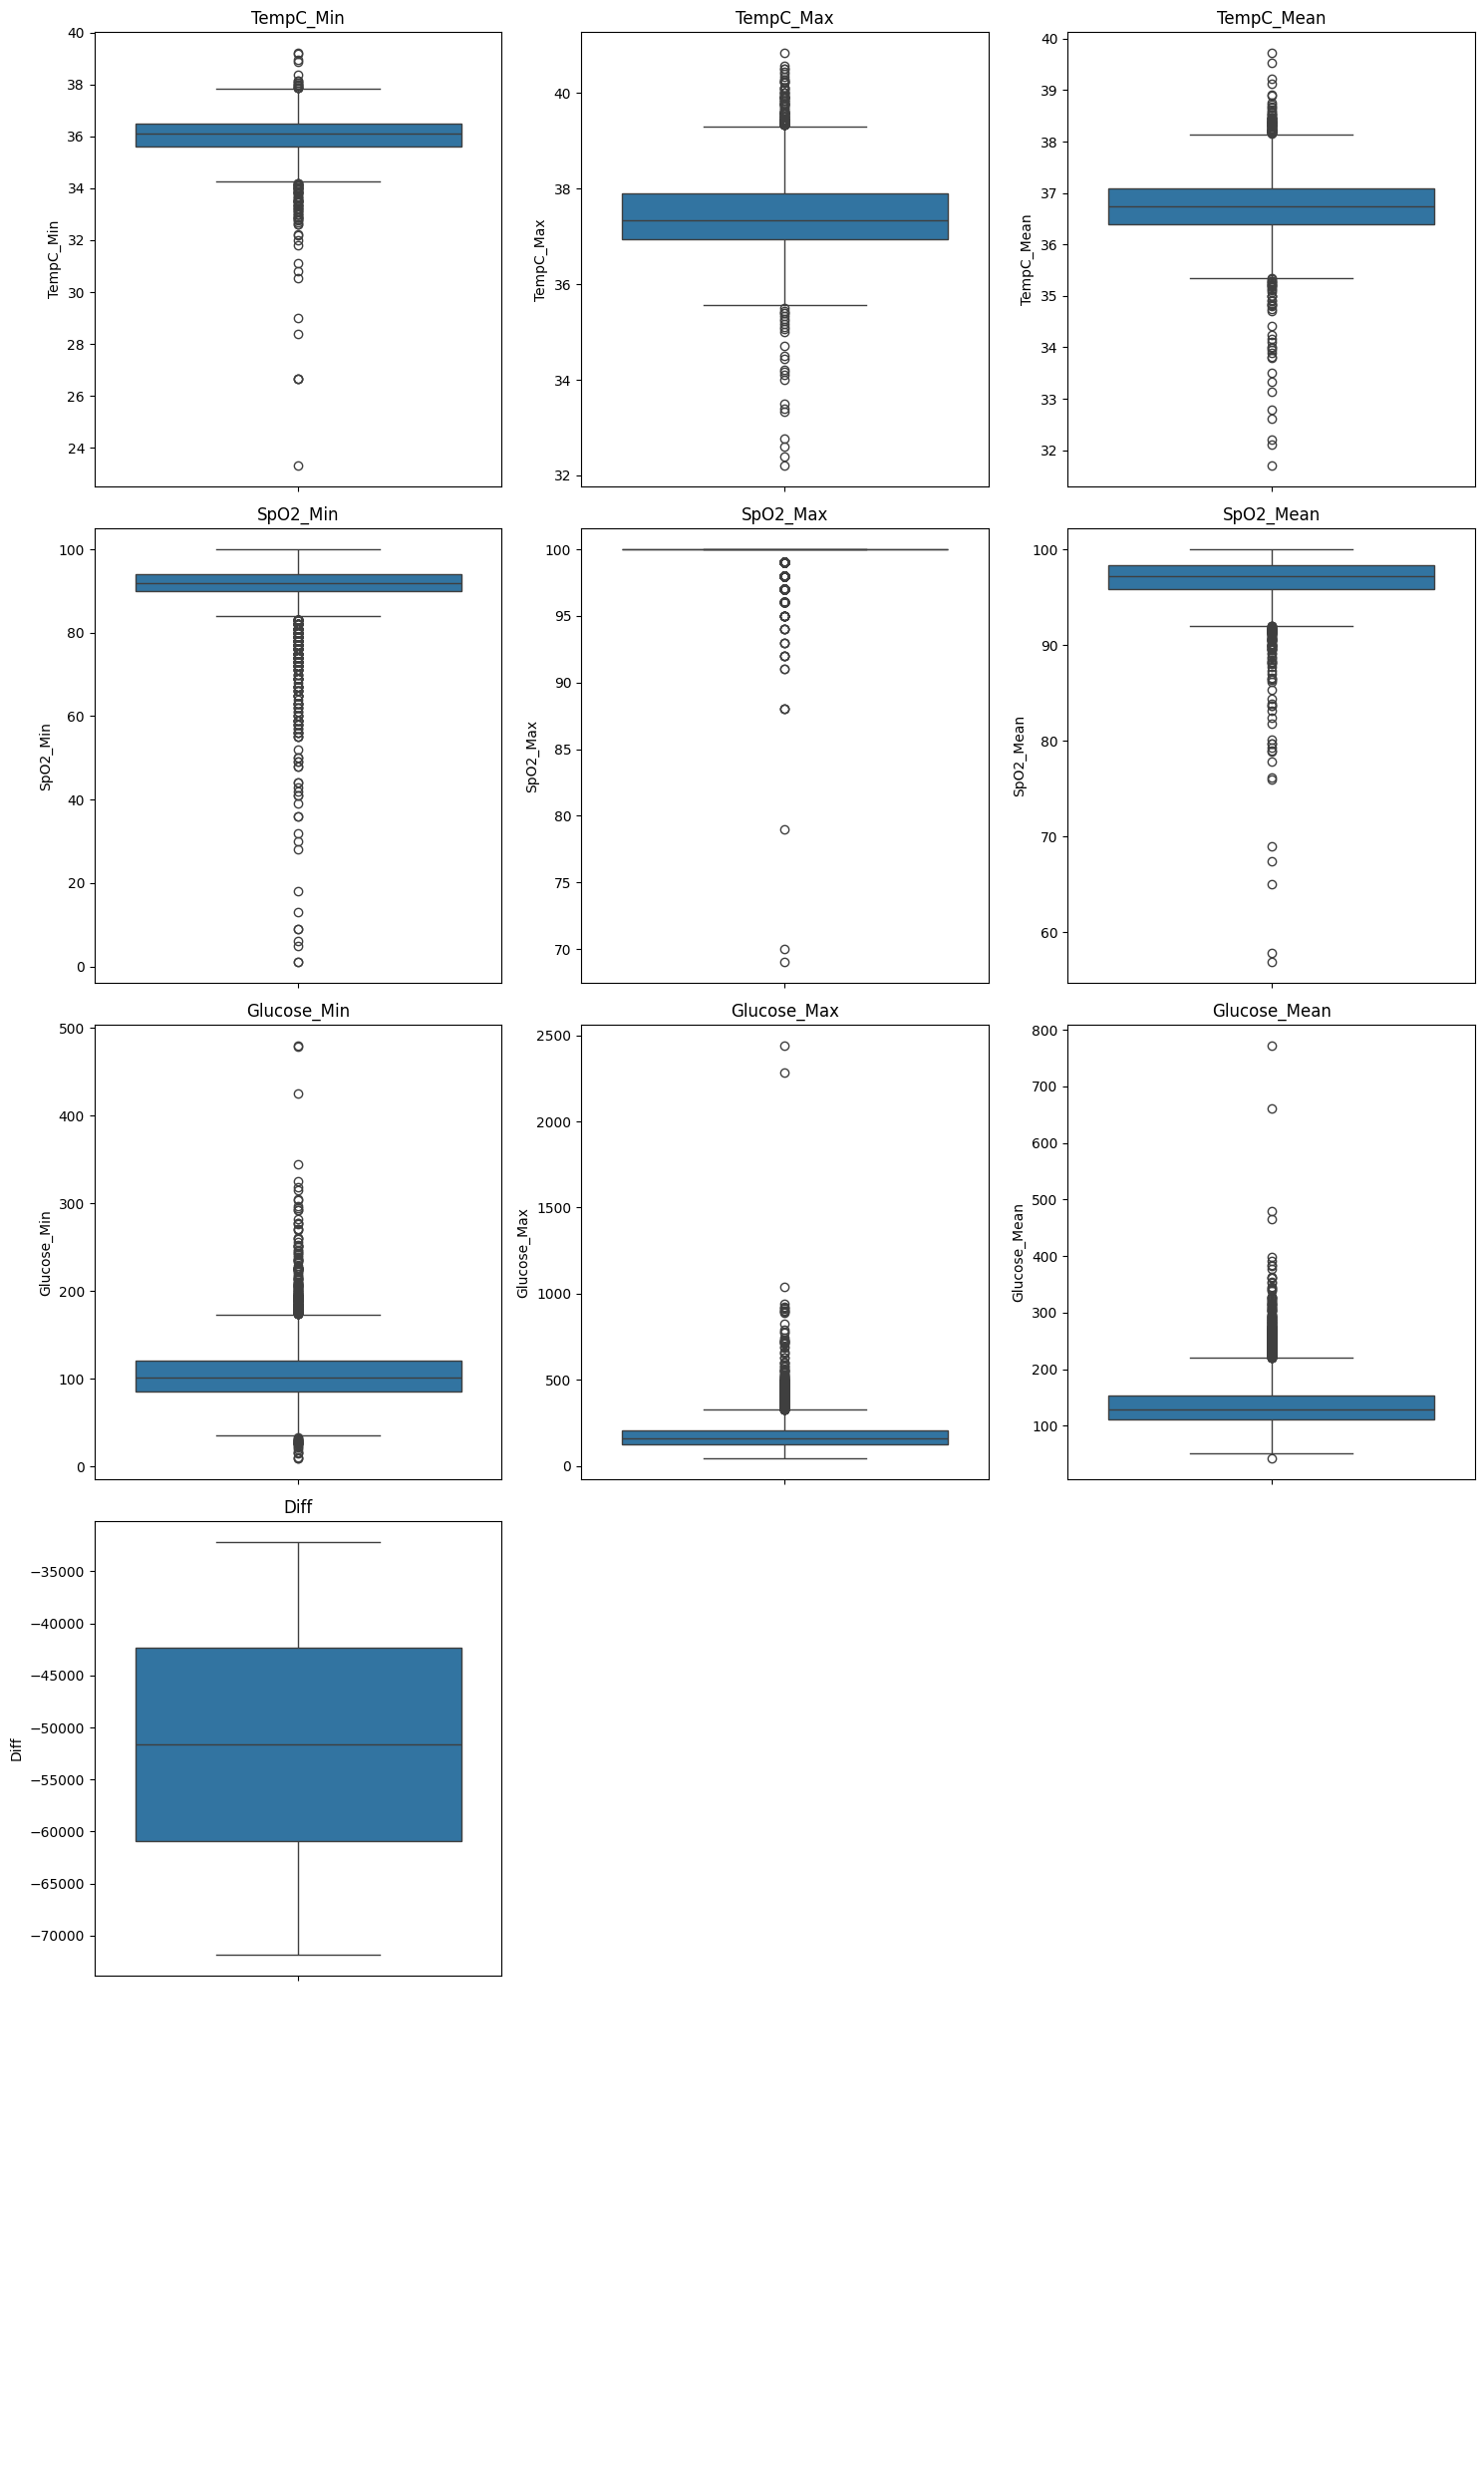

In [87]:
if EDA:
    # 1. Choose which features you actually want to boxplot
    #    (numeric only is usually what you want here)
    num_features = train_model_clean[feature_cols].select_dtypes(include=np.number).columns.tolist()

    ncols = 3
    nrows = 5                     # fixed grid: 5 rows x 3 cols = 15 plots per figure
    plots_per_fig = nrows * ncols

    # 2. Loop over features in chunks of 15
    for start in range(0, len(num_features), plots_per_fig):
        subset = num_features[start:start + plots_per_fig]

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                                 figsize=(15, 5 * nrows))

        # Make axes always a flat 1D array for simple indexing
        axes = np.array(axes).ravel()

        # 3. Draw each boxplot
        for i, feat in enumerate(subset):
            ax = axes[i]

            # Optional: sample rows if dataset is big to speed up plotting
            data_to_plot = train[feat]
            if len(train_model_clean) > 5000:
                data_to_plot = data_to_plot.sample(5000, random_state=0)

            sns.boxplot(y=data_to_plot, ax=ax)
            ax.set_title(feat)

        # 4. Turn off any leftover empty axes
        for j in range(len(subset), len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()


In [57]:
# Now we analyze the correlation matrix of the numerical columns

if EDA:
    corr = train_model_clean[num_features].corr()
    display(corr.style.background_gradient(cmap='coolwarm', axis=None).format("{:.4f}"))

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff
HeartRate_Min,1.0000,0.5347,0.8360,0.0387,-0.1029,-0.0528,0.1687,0.0553,0.1896,0.1115,-0.0078,0.0979,0.2126,0.2198,0.2786,0.1720,0.2058,0.2319,0.0373,-0.0536,-0.0265,0.0284,0.0337,0.0395,-0.0038
HeartRate_Max,0.5347,1.0000,0.8154,-0.1480,0.0444,-0.0778,0.0437,0.1814,0.1763,-0.0477,0.1179,0.0949,0.1178,0.3315,0.2959,0.0655,0.2813,0.2127,-0.1303,0.0208,-0.0577,0.0239,0.0653,0.0631,-0.0034
HeartRate_Mean,0.8360,0.8154,1.0000,-0.0864,-0.0417,-0.0886,0.1098,0.1261,0.2062,0.0199,0.0639,0.1057,0.1824,0.3254,0.3445,0.1204,0.2779,0.2522,-0.0952,-0.0263,-0.0824,0.0334,0.0661,0.0692,-0.0009
SysBP_Min,0.0387,-0.1480,-0.0864,1.0000,0.3378,0.7463,0.5824,0.1763,0.4909,0.6757,0.0818,0.6084,0.0772,-0.1344,-0.0761,0.1729,-0.0239,0.0871,0.2088,-0.0669,0.0484,0.0933,-0.0307,0.0155,-0.0033
SysBP_Max,-0.1029,0.0444,-0.0417,0.3378,1.0000,0.7502,0.1538,0.5304,0.3630,0.2061,0.4811,0.5764,-0.0490,0.0386,-0.0184,0.0269,0.1096,0.0978,-0.0125,0.0518,0.0433,0.0438,0.0942,0.1011,-0.0184
SysBP_Mean,-0.0528,-0.0778,-0.0886,0.7463,0.7502,1.0000,0.4252,0.3967,0.5505,0.5121,0.3142,0.7761,0.0241,-0.0645,-0.0542,0.1212,0.0381,0.1051,0.1133,-0.0069,0.0540,0.0961,0.0528,0.0888,-0.0190
DiasBP_Min,0.1687,0.0437,0.1098,0.5824,0.1538,0.4252,1.0000,0.2407,0.7486,0.7478,0.1128,0.6905,0.0323,-0.0904,-0.0697,0.1391,-0.0011,0.0835,0.1642,-0.0631,0.0468,0.0405,-0.0599,-0.0362,0.0069
DiasBP_Max,0.0553,0.1814,0.1261,0.1763,0.5304,0.3967,0.2407,1.0000,0.5795,0.1786,0.5820,0.5494,0.0360,0.0914,0.0670,0.0288,0.0443,0.0403,-0.0437,-0.0038,-0.0217,0.0485,0.0169,0.0340,-0.0108
DiasBP_Mean,0.1896,0.1763,0.2062,0.4909,0.3630,0.5505,0.7486,0.5795,1.0000,0.5836,0.3242,0.9010,0.0537,-0.0054,0.0053,0.1094,0.0058,0.0650,0.0854,-0.0550,0.0081,0.0693,-0.0312,-0.0021,-0.0001
MeanBP_Min,0.1115,-0.0477,0.0199,0.6757,0.2061,0.5121,0.7478,0.1786,0.5836,1.0000,0.0719,0.6309,0.0296,-0.1192,-0.0926,0.1428,-0.0124,0.0820,0.1882,-0.0546,0.0584,0.0494,-0.0561,-0.0261,0.0037


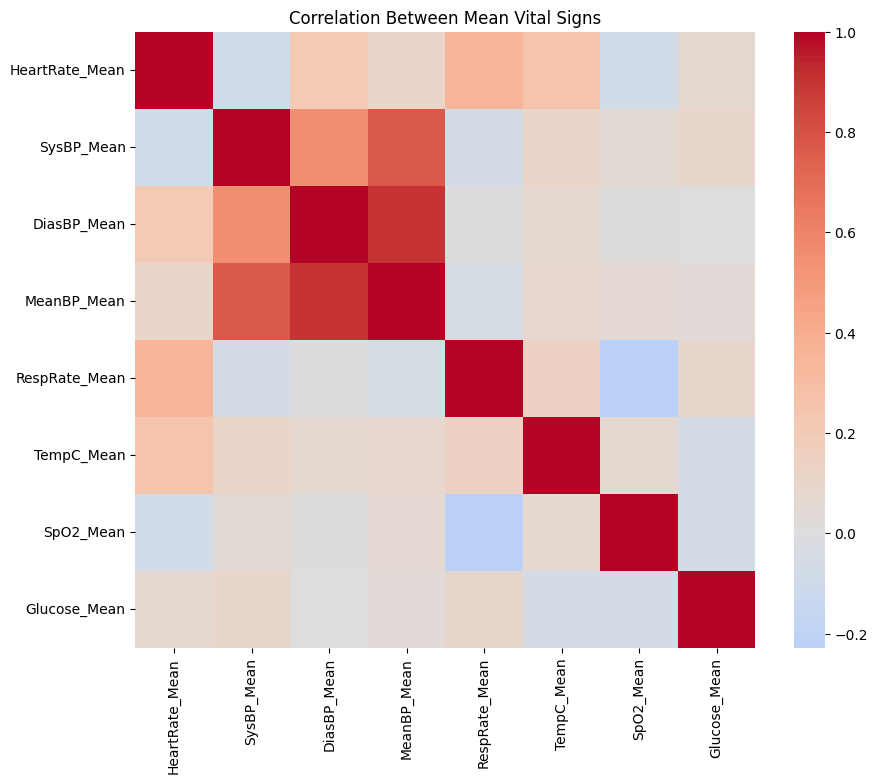

In [93]:
#focusing on vital means correlation heatmap

corr = train_model_clean[vital_means].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Between Mean Vital Signs")
plt.show()


Observations:
* Heart rate and respiration rate are moderately positively correlated
* Systolic, Diastolic BP and MeanBP are highly correlated, as expected
* SpO2 and Respiratory Rate are negatively correlated, as expected
* Heart rate and Respiration Rate and TempC are positively correlated
* Glucose is negatively correlated with Temperature and SpO2

In [94]:
# Mean vitals by survival vs death
grouped_vitals = (
    train_model_clean
    .groupby(target_col)[vital_means]
    .mean()
    .T
)

grouped_vitals


HOSPITAL_EXPIRE_FLAG,0,1
HeartRate_Mean,84.577185,89.954442
SysBP_Mean,119.908693,113.094355
DiasBP_Mean,62.901682,59.417750
MeanBP_Mean,78.058865,74.052180
RespRate_Mean,18.746174,20.882049
TempC_Mean,36.775155,36.562954
SpO2_Mean,96.996370,95.833809
Glucose_Mean,137.555563,151.281862


### 1.5 Analyze temporal patterns (age at admission, time-based features)

In [ ]:
# Calculate age at admission

if {"DOB", "ADMITTIME"}.issubset(train_model_clean.columns):
    # Convert to datetime if not already (invalid values -> NaT)
    train_model_clean["DOB"] = pd.to_datetime(train_model_clean["DOB"], errors="coerce")
    train_model_clean["ADMITTIME"] = pd.to_datetime(train_model_clean["ADMITTIME"], errors="coerce")

    # Initialize AGE column
    train_model_clean["AGE"] = np.nan

    # Build mask of rows where both dates are valid
    valid_mask = train_model_clean["DOB"].notna() & train_model_clean["ADMITTIME"].notna()

    if valid_mask.any():
        dob = train_model_clean.loc[valid_mask, "DOB"]
        adm = train_model_clean.loc[valid_mask, "ADMITTIME"]

        # Compute integer age in years without subtracting datetimes (avoids overflow)
        years = adm.dt.year - dob.dt.year
        had_birthday = (adm.dt.month > dob.dt.month) | ((adm.dt.month == dob.dt.month) & (adm.dt.day >= dob.dt.day))
        age_years = years - (~had_birthday).astype(int)

        # Assign computed ages back
        train_model_clean.loc[valid_mask, "AGE"] = age_years

    # Clamp ages to sensible range: 0 <= AGE <= 120, otherwise set NaN
    mask_invalid_age = (train_model_clean["AGE"] < 0) | (train_model_clean["AGE"] > 120)
    train_model_clean.loc[mask_invalid_age, "AGE"] = np.nan

    print(train_model_clean["AGE"].describe())

Valid DOB fraction   : 0.577
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: AGE, dtype: float64
